# mom6_bathy Notebook Gallery
## Spherical grid with equatorial refinement

In this notebook, we create a spherical grid with uniform resolution. We then increase the resolution around the equator by a factor of two by providing new, custom x and y coordinates array for the supergrid.

## 1. Import Modules

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from mom6_bathy.grid import Grid
from mom6_bathy.topo import Topo

## 2. Create a horizontal MOM6 grid

Spherical grid. x coordinates interval= [0, 360] degrees. y coordinates interval = [-80,+80] degrees

In [2]:
# Instantiate a MOM6 grid instance
grid = Grid(
    nx         = 180,         # Number of grid points in x direction
    ny         = 80,          # Number of grid points in y direction
    lenx       = 360.0,       # grid length in x direction, e.g., 360.0 (degrees)
    leny       = 160,         # grid length in y direction
    cyclic_x   = True,      # reentrant, spherical domain
    ystart     = -80          # start/end 10 degrees above/below poles to avoid singularity 
)

### Plot grid properties:

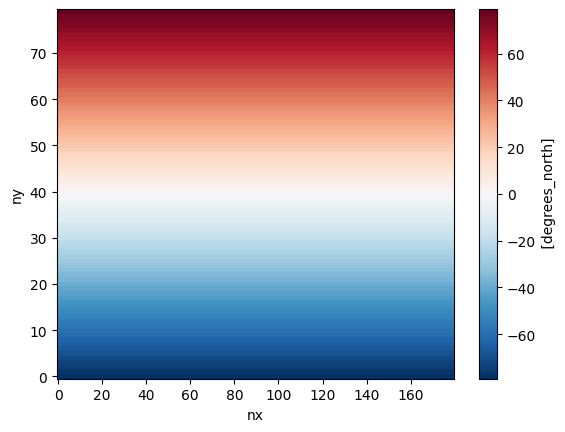

In [3]:
grid.tlat.plot();

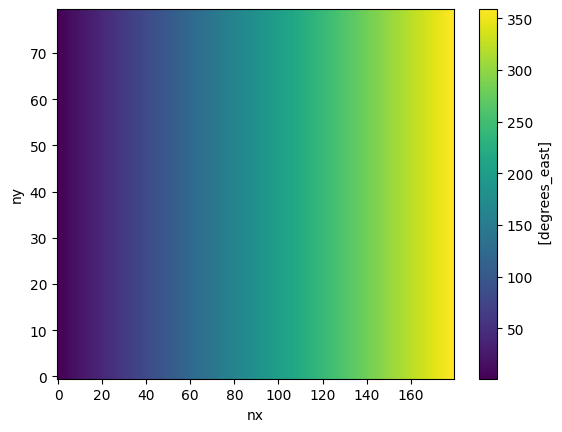

In [4]:
grid.tlon.plot();

### *Customize the grid resolution around the equator*
To do so, we provide new x and y coordinate arrays for the supergrid

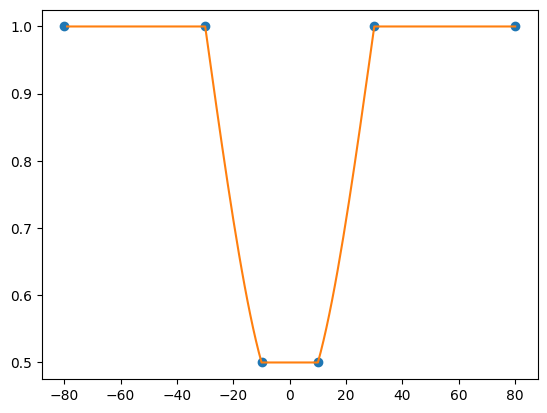

In [5]:
# First, define a refinement function along longitutes:
from scipy import interpolate
f = 0.5
r_y = [-80,-30,-10,10,30,80] # transition latitudes
r_f = [1,1,f,f,1,1]          # inverse refinement factors at transition latitudes
interp_func = interpolate.interp1d(r_y, r_f, kind=3)
r_f_mapped = interp_func(grid.supergrid.y[1:,0])
r_f_mapped = np.where(r_f_mapped < 1.0, r_f_mapped, 1.0)
r_f_mapped = np.where(r_f_mapped > f, r_f_mapped, f)
plt.plot(r_y, r_f, 'o', grid.supergrid.y[1:,0], r_f_mapped, '-');

Now apply the above refinement function (`r_f_mapped`) to the y coordinates of the original supergrid:

In [6]:
super_dy = grid.supergrid.y[1:,0] - grid.supergrid.y[:-1,0]
super_dy_new = super_dy.mean() * r_f_mapped / r_f_mapped.mean() # normalize
super_y_new = grid.supergrid.y[:,0].copy()
super_y_new[1:] = grid.supergrid.y[0,0] + super_dy_new.cumsum()
xdat, ydat = np.meshgrid(grid.supergrid.x[0,:], super_y_new)

Update the supergrid:

In [7]:
grid.update_supergrid(xdat, ydat)

Confirm that the equatorial resolution is increased by a factor of two:

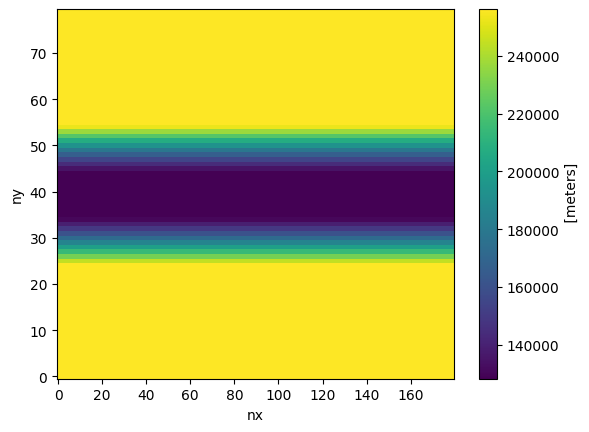

In [8]:
grid.dyt.plot()

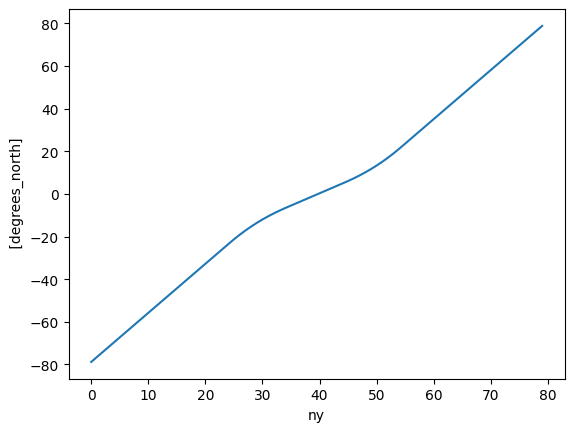

In [9]:
grid.tlat.isel(nx=0).plot()

## 3. Configure the bathymetry

In [10]:
# Instantiate a Topo object associated with the horizontal grid object (grid).
topo = Topo(grid, min_depth=10.0)

### *flat bottom bathymetry*

In [11]:
# Set the bathymetry to be a flat bottom with a depth of 2000m
topo.set_flat(D=2000.0)

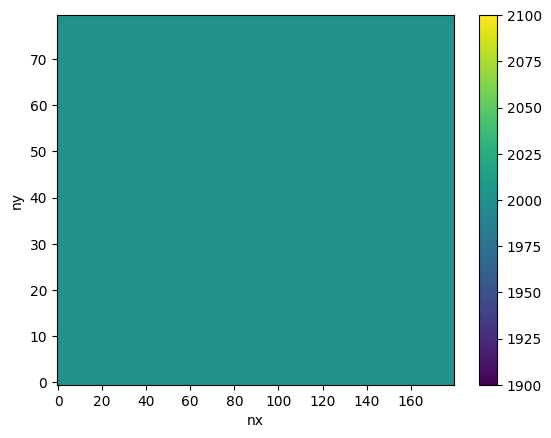

In [12]:
topo.depth.plot()

## 4. Save the grid and bathymetry files

In [13]:
# MOM6 supergrid file:
grid.write_supergrid("./ocean_hgrid_2.nc")

# MOM6 topography file:
topo.write_topo("./ocean_topog_2.nc")

# CICE grid file:
topo.write_cice_grid("./cice_grid_2.nc")

# ESMF mesh file:
topo.write_esmf_mesh("./ESMF_mesh_2.nc")